In [1]:
!pip install ptflops
!pip install torch-pruning

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
import copy
import torch.nn.utils.prune as prune
import time

from sklearn.metrics import roc_auc_score

In [4]:
# Unlabelled dataset
class UnlabelledJetDataset(Dataset):
    def __init__(self, h5_file, dataset_name='jet'):
        self.h5_file = h5_file
        self.dataset_name = dataset_name
        with h5py.File(h5_file, 'r') as f:
            self._len = len(f[dataset_name])

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            jet_image = f[self.dataset_name][idx]  # Shape: [125, 125, 8]
        # Transpose to [channels, height, width]
        jet_image = np.transpose(jet_image, (2, 0, 1))  # [8, 125, 125]
        # Per-channel normalization
        for c in range(jet_image.shape[0]):
            channel_max = np.max(jet_image[c])
            if channel_max > 0:
                jet_image[c] /= channel_max
        # Pad from (8,125,125) to (8,128,128)
        jet_image = np.pad(jet_image, pad_width=((0,0),(1,2),(1,2)), mode='constant', constant_values=0)
        return torch.tensor(jet_image, dtype=torch.float32)

# Labelled dataset
class LabelledJetDataset(Dataset):
    def __init__(self, h5_file, dataset_name='jet', label_name='Y'):
        self.h5_file = h5_file
        self.dataset_name = dataset_name
        self.label_name = label_name
        with h5py.File(h5_file, 'r') as f:
            self._len = len(f[dataset_name])

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            jet_image = f[self.dataset_name][idx]  # [125,125,8]
            label = f[self.label_name][idx]
        jet_image = np.transpose(jet_image, (2, 0, 1))  # [8,125,125]
        for c in range(jet_image.shape[0]):
            channel_max = np.max(jet_image[c])
            if channel_max > 0:
                jet_image[c] /= channel_max
        jet_image = np.pad(jet_image, pad_width=((0,0),(1,2),(1,2)), mode='constant', constant_values=0)
        return torch.tensor(jet_image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [5]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_shape=(8, 128, 128), latent_dim=128):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Enhanced Encoder with BatchNorm and LeakyReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        self.fc_enc = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Enhanced Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*8*8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),    # 64x64 -> 128x128
            nn.Sigmoid()
        )


        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_enc(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        # Clamp logvar to avoid extremely small or large values
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def decode(self, z):
        h = F.leaky_relu(self.decoder_input(z), 0.2)
        h = h.view(-1, 128, 8, 8)  # Reshape to (batch_size, 128, 8, 8)
        return self.decoder(h)

In [16]:
# Training Components
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """Enhanced loss with KL annealing"""
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def train_enhanced_vae(model, dataloader, optimizer, scheduler, device, epoch, annealing_epochs=20):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    # KL annealing
    beta = min(1.0, epoch / annealing_epochs)

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar, beta)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_recon += F.mse_loss(recon, batch, reduction='sum').item()
        total_kl += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)
    avg_kl = total_kl / len(dataloader.dataset)

    scheduler.step(avg_loss)

    print(f'Epoch {epoch+1}:')
    print(f'  Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}')
    print(f'  LR: {optimizer.param_groups[0]["lr"]:.2e} | Beta: {beta:.2f}')

    return avg_loss

In [17]:
import torch
import torch.optim as optim
from torch.nn import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(latent_dim=128)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training")
    vae = DataParallel(vae)

vae.to(device)

# Adam with weight decay
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

unlabelled_dataset = UnlabelledJetDataset('../Dataset_Specific_Unlabelled.h5')
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=128, shuffle=True, num_workers=16)

Using 4 GPUs for training


In [18]:
# Training Loop (50 Epochs)
best_loss = float('inf')
patience_counter = 0
patience = 10
loss_history = []

for epoch in range(50):
    epoch_loss = train_enhanced_vae(vae, unlabelled_loader, optimizer, scheduler, device, epoch)
    loss_history.append(epoch_loss)


    # Save checkpoints
    if (epoch+1) % 5 == 0:
        torch.save(vae.state_dict(), f'./vae_enhanced_epoch_{epoch+1}.pth')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        torch.save(vae.state_dict(), './vae_enhanced_best.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Final save
torch.save(vae.state_dict(), './vae_enhanced_final.pth')

Epoch 1:
  Loss: 3829.0584 | Recon: 3829.0584 | KL: 27560.3194
  LR: 1.00e-03 | Beta: 0.00
Epoch 2:
  Loss: 125.7257 | Recon: 122.3777 | KL: 66.9604
  LR: 1.00e-03 | Beta: 0.05
Epoch 3:
  Loss: 123.2921 | Recon: 120.7074 | KL: 25.8476
  LR: 1.00e-03 | Beta: 0.10
Epoch 4:
  Loss: 123.4464 | Recon: 120.4840 | KL: 19.7497
  LR: 1.00e-03 | Beta: 0.15
Epoch 5:
  Loss: 123.8855 | Recon: 120.5550 | KL: 16.6529
  LR: 1.00e-03 | Beta: 0.20
Epoch 6:
  Loss: 124.3407 | Recon: 120.7369 | KL: 14.4153
  LR: 1.00e-03 | Beta: 0.25
Epoch 7:
  Loss: 124.7865 | Recon: 120.9206 | KL: 12.8864
  LR: 5.00e-04 | Beta: 0.30
Epoch 8:
  Loss: 124.9472 | Recon: 120.8858 | KL: 11.6042
  LR: 5.00e-04 | Beta: 0.35
Epoch 9:
  Loss: 125.3488 | Recon: 121.0734 | KL: 10.6886
  LR: 5.00e-04 | Beta: 0.40
Epoch 10:
  Loss: 125.7729 | Recon: 121.3090 | KL: 9.9198
  LR: 5.00e-04 | Beta: 0.45
Epoch 11:
  Loss: 126.1847 | Recon: 121.5334 | KL: 9.3027
  LR: 2.50e-04 | Beta: 0.50
Epoch 12:
  Loss: 126.4218 | Recon: 121.6496 | KL

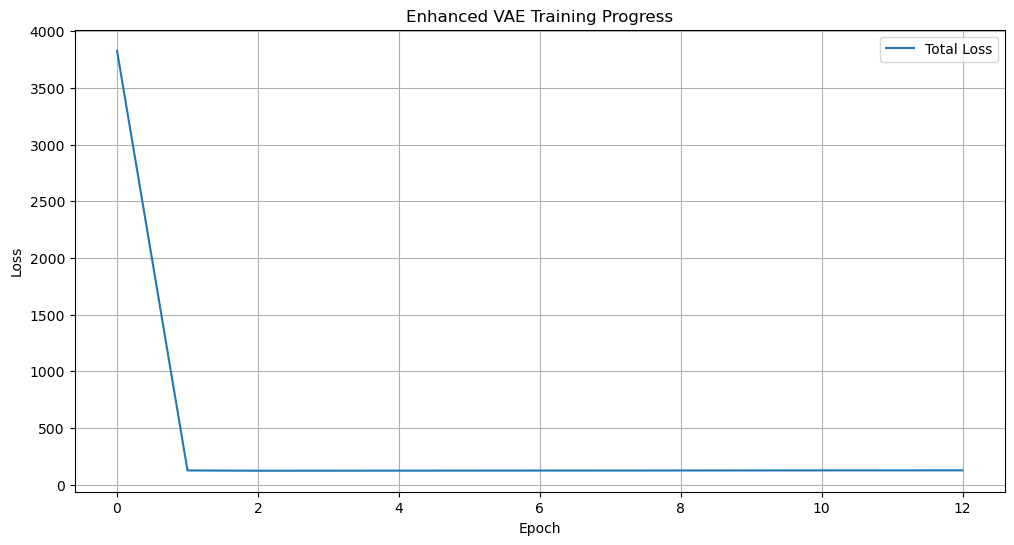

In [19]:
# Training Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Total Loss')
plt.title('Enhanced VAE Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('./enhanced_training_curve.png')
plt.show()

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ---------------------------
# 1. Visualization of Reconstructions
# ---------------------------
def visualize_reconstructions(model, dataloader, device, num_images=8, display_channel=0):
    model.eval()
    originals, reconstructions = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            originals.append(batch.cpu())
            reconstructions.append(recon.cpu())
            if torch.cat(originals, dim=0).size(0) >= num_images:
                break
    originals = torch.cat(originals, dim=0)[:num_images]
    reconstructions = torch.cat(reconstructions, dim=0)[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images*2, 4))
    for i in range(num_images):
        # If the image has more than 3 channels, display only the specified channel.
        img_orig = originals[i]
        img_recon = reconstructions[i]
        if img_orig.shape[0] not in [1, 3]:
            # Display only the chosen channel
            img_orig_disp = img_orig[display_channel].numpy()
            img_recon_disp = img_recon[display_channel].numpy()
            axes[0, i].imshow(img_orig_disp, cmap='gray')
            axes[1, i].imshow(img_recon_disp, cmap='gray')
        else:
            # For images with 1 or 3 channels, display normally
            if img_orig.shape[0] == 1:
                axes[0, i].imshow(img_orig.squeeze(0).numpy(), cmap='gray')
                axes[1, i].imshow(img_recon.squeeze(0).numpy(), cmap='gray')
            else:
                axes[0, i].imshow(np.transpose(img_orig.numpy(), (1, 2, 0)))
                axes[1, i].imshow(np.transpose(img_recon.numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title("Originals")
    axes[1, 0].set_title("Reconstructions")
    plt.show()


In [21]:
# ---------------------------
# 2. Latent Space Visualization (PCA/t-SNE)
# ---------------------------
def visualize_latent_space(model, dataloader, device, method='pca', num_samples=1000):
    model.eval()
    latents = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            mu, _ = model.module.encode(batch)
            latents.append(mu.cpu().numpy())
            if np.concatenate(latents, axis=0).shape[0] >= num_samples:
                break
    latents = np.concatenate(latents, axis=0)[:num_samples]

    if method.lower() == 'pca':
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latents)
    elif method.lower() == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(latents)
    else:
        raise ValueError("Unknown method. Choose 'pca' or 'tsne'.")

    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=2, alpha=0.7)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.show()


# ---------------------------
# 3. Histogram of Latent Variables
# ---------------------------
def plot_latent_histograms(model, dataloader, device, num_bins=30, num_samples=1000):
    model.eval()
    latents = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            mu, _ = model.module.encode(batch)
            latents.append(mu.cpu().numpy())
            if np.concatenate(latents, axis=0).shape[0] >= num_samples:
                break
    latents = np.concatenate(latents, axis=0)[:num_samples]

    latent_dim = latents.shape[1]
    cols = 4
    rows = (latent_dim + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten()
    for i in range(latent_dim):
        axes[i].hist(latents[:, i], bins=num_bins, alpha=0.7)
        axes[i].set_title(f"Latent Dimension {i}")

    for j in range(latent_dim, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


# ---------------------------
# 4. Latent Interpolation
# ---------------------------
def latent_interpolation(model, z1, z2, num_steps=10, device='gpu', display_channel=0):
    model.eval()
    interpolated_images = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, num_steps):
            z = (1 - alpha) * z1 + alpha * z2
            z = z.to(device)
            recon = model.decode(z.unsqueeze(0))
            interpolated_images.append(recon.cpu().squeeze(0))

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps*2, 2))
    for i in range(num_steps):
        img = interpolated_images[i]
        if img.shape[0] not in [1, 3]:
            img_disp = img[display_channel].numpy()
            axes[i].imshow(img_disp, cmap='gray')
        elif img.shape[0] == 1:
            axes[i].imshow(img.squeeze(0).numpy(), cmap='gray')
        else:
            axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle("Latent Interpolation")
    plt.show()


# ---------------------------
# 5. Generate Samples from the Prior
# ---------------------------
def generate_samples_from_prior(model, num_samples=10, device='cpu', display_channel=0):
    model.eval()
    latent_dim = model.latent_dim if hasattr(model, 'latent_dim') else 64
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        samples = model.decode(z)
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
    for i in range(num_samples):
        img = samples[i].cpu()
        if img.shape[0] not in [1, 3]:
            img_disp = img[display_channel].numpy()
            axes[i].imshow(img_disp, cmap='gray')
        elif img.shape[0] == 1:
            axes[i].imshow(img.squeeze(0).numpy(), cmap='gray')
        else:
            axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle("Generated Samples from Prior")
    plt.show()

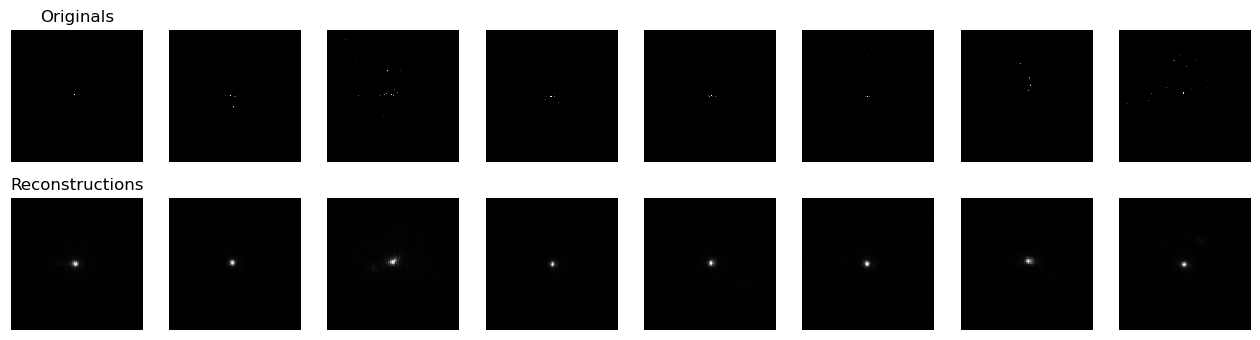

In [24]:
visualize_reconstructions(vae, unlabelled_loader, device)

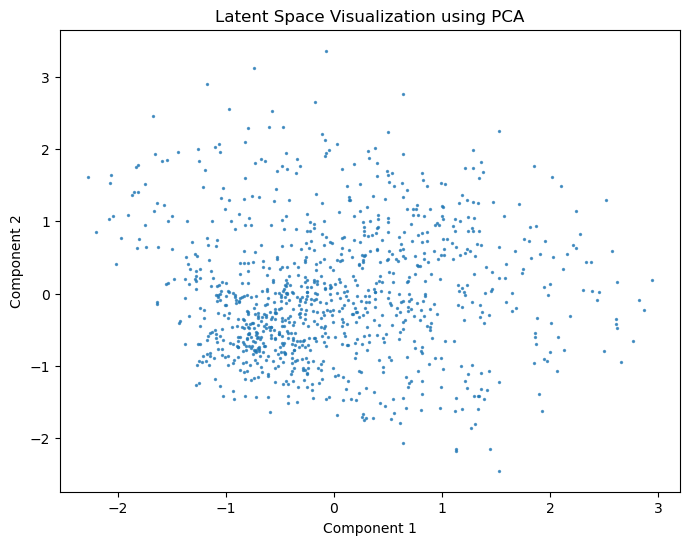

In [23]:
visualize_latent_space(vae, unlabelled_loader, device, method='pca')

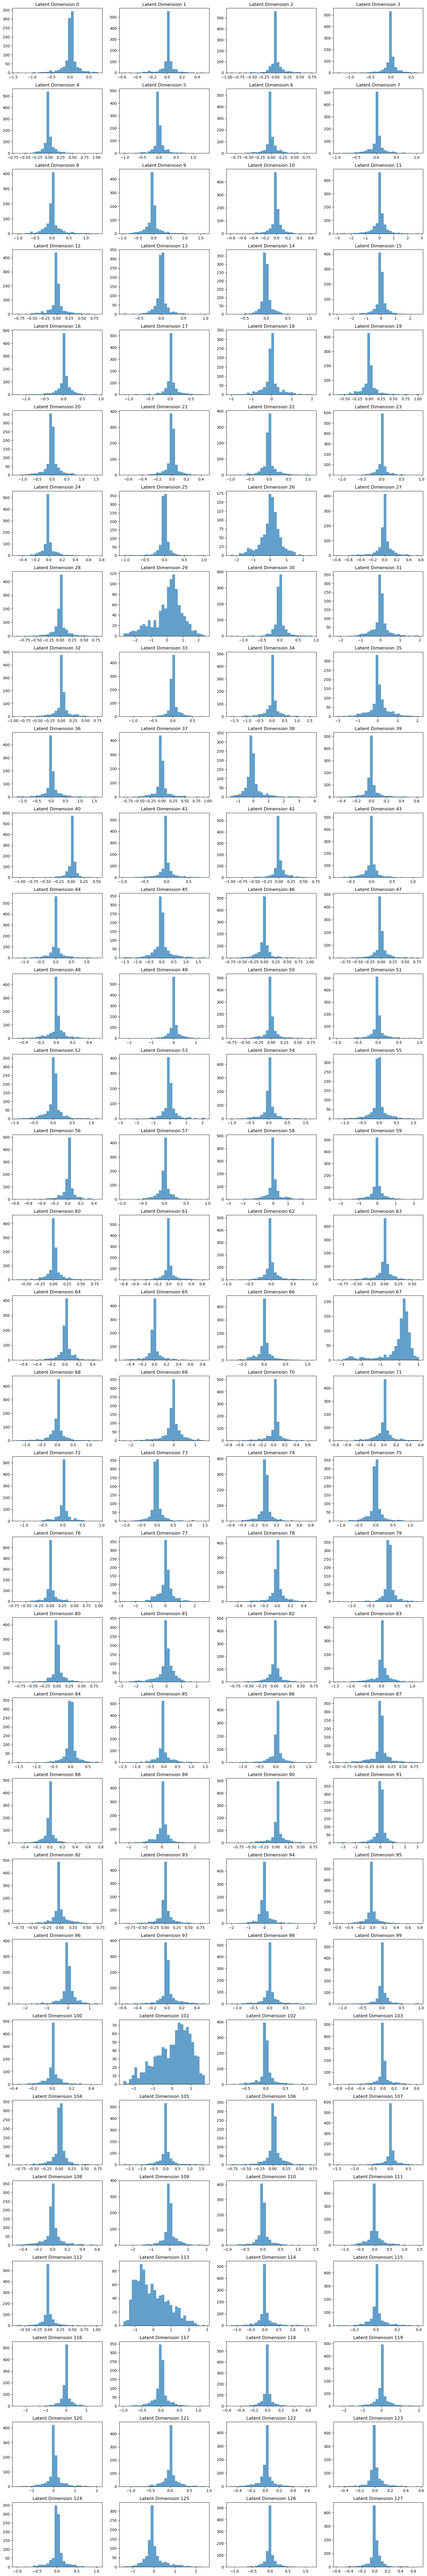

In [25]:
plot_latent_histograms(vae, unlabelled_loader, device)

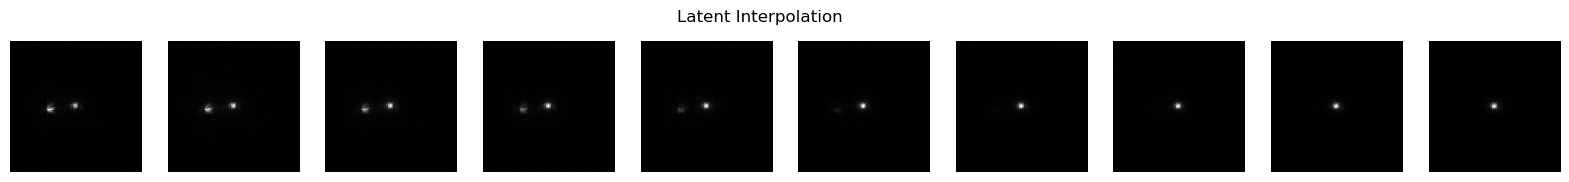

In [26]:
# Getting two batches of images from the unlabelled loader
x1 = next(iter(unlabelled_loader))
x2 = next(iter(unlabelled_loader))

with torch.no_grad():
    z1, _ = vae.module.encode(x1.to(device))
    z2, _ = vae.module.encode(x2.to(device))

# Using the first sample from each batch for interpolation
latent_interpolation(vae.module, z1[0], z2[0], num_steps=10, device=device)

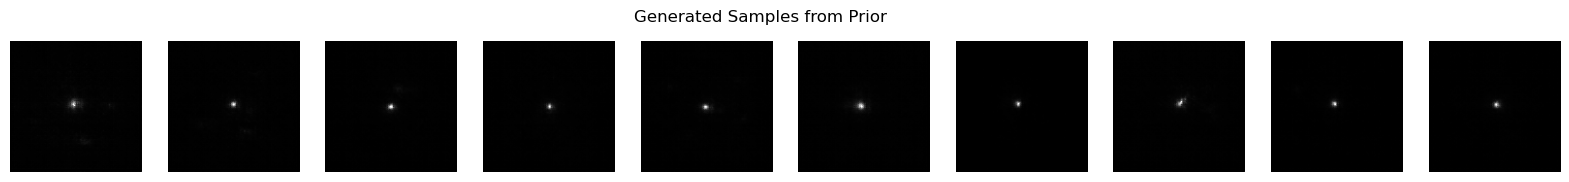

In [27]:
generate_samples_from_prior(vae.module, num_samples=10, device=device)

In [28]:
# Training SVM classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

unlabelled_dataset = UnlabelledJetDataset('../Dataset_Specific_Unlabelled.h5')
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=128, shuffle=True)

labelled_dataset = LabelledJetDataset('../Dataset_Specific_labelled.h5')
labelled_loader = DataLoader(labelled_dataset, batch_size=128, shuffle=False)

Using device: cuda


In [29]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

In [30]:
# Extracting latent vectors from labelled dataset & training SVM
print("\n==> Extracting latent vectors from labelled dataset and training SVM...\n")
vae.module.eval()

latent_list = []
label_list = []
with torch.no_grad():
    for images, labels in labelled_loader:
        images = images.to(device)
        mu, _ = vae.module.encode(images)  # shape: [B, latent_dim]
        latent_list.append(mu.cpu().numpy())
        label_list.append(labels.cpu().numpy())

X_latent = np.concatenate(latent_list, axis=0)  # shape: [N, latent_dim]
y_labels = np.concatenate(label_list, axis=0).ravel()  # shape: [N]

# Training an SVM on the latent codes
svm_clf = SVC(kernel='rbf', C=1.0)
svm_clf.fit(X_latent, y_labels)

# Evaluating on the same set
y_pred = svm_clf.predict(X_latent)
acc = accuracy_score(y_labels, y_pred)
print(f"SVM Accuracy on the labelled training set: {acc:.4f}")


==> Extracting latent vectors from labelled dataset and training SVM...

SVM Accuracy on the labelled training set: 0.7755


In [31]:
print(X_latent, y_labels)

[[-1.94203883e-01  2.09601745e-02 -1.27729699e-01 ... -3.53350282e-01
  -7.75014311e-02  1.06506392e-01]
 [ 4.16844673e-02  2.71583237e-02  4.88274917e-03 ... -6.56681284e-02
   2.59554945e-04 -1.38673931e-02]
 [ 6.59270436e-02  2.70720646e-02  2.88488530e-03 ... -1.81697726e-01
   1.17128035e-02 -1.39032230e-02]
 ...
 [ 1.12177394e-02  2.17648707e-02  1.31530315e-03 ... -1.14364177e-03
  -3.92103568e-03 -9.43832286e-03]
 [ 5.12860596e-01 -1.72132477e-02 -9.05091912e-02 ...  5.18579781e-01
  -6.12065569e-02  1.75281465e-01]
 [ 1.58021480e-01 -4.98230755e-02 -1.13444090e-01 ...  5.26041985e-01
  -1.22924402e-01 -6.75967857e-02]] [1. 0. 0. ... 0. 0. 1.]


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Creating a GridSearchCV object
grid_search = GridSearchCV(
    estimator=SVC(),      # model to be tuned
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,                 # 3-fold cross-validation
    verbose=2,
    n_jobs=-1            
)

grid_search.fit(X_latent, y_labels)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Training the final SVM with the best parameters
best_svm = grid_search.best_estimator_

# Evaluating on the same training set
y_pred = best_svm.predict(X_latent)
acc = accuracy_score(y_labels, y_pred)
print(f"SVM accuracy on the training set with best params: {acc:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7417998848475129
SVM accuracy on the training set with best params: 0.8312


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.236290
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.837685
[t-SNE] KL divergence after 1000 iterations: 1.823586


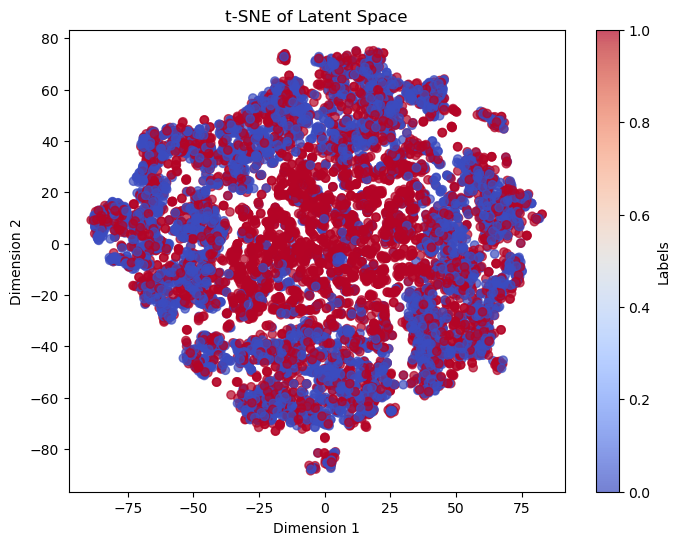

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=42)
X_2d = tsne.fit_transform(X_latent)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Labels')
plt.title("t-SNE of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [34]:
import pickle

# Saving the svm model to a file
with open("./best_svm_model.pkl", "wb") as file:
    pickle.dump(best_svm, file)

In [35]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_svm_roc_curve(svm_clf, X_latent, y_labels):
    """
    Plots the ROC curve and computes the AUC for a trained SVM classifier.

    Args:
        svm_clf: A trained SVC model (sklearn.svm.SVC).
        X_latent: Numpy array of shape [N, latent_dim] for the features.
        y_labels: Numpy array of shape [N] with binary labels (0 or 1).
    """
    y_scores = svm_clf.decision_function(X_latent)

    # Computing ROC curve
    fpr, tpr, thresholds = roc_curve(y_labels, y_scores)

    # Computing AUC
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

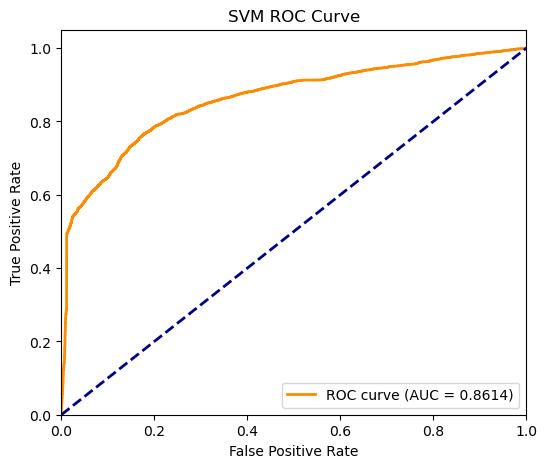

In [36]:
plot_svm_roc_curve(svm_clf, X_latent, y_labels)

In [37]:
# training a general classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
# ---------------------------
# Classifier Definition
# ---------------------------
class Classifier(nn.Module):
    def __init__(self, vae, latent_dim=64):
        super(Classifier, self).__init__()
        self.vae = vae  # Pretrained VAE; encoder remains trainable for fine tuning.
        self.classifier_net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        mu, _ = self.vae.encode(x)
        return self.classifier_net(mu)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Creating the labelled dataset
dataset = LabelledJetDataset('../Dataset_Specific_labelled.h5')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)


if isinstance(vae, nn.DataParallel):
    vae = vae.module
vae.to(device)


# Creating the classifier (fine tuning the encoder, hence updating weights)
classifier = Classifier(vae, latent_dim=128).to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for classifier training")
    classifier = nn.DataParallel(classifier)

Using device: cuda
Using 4 GPUs for classifier training


In [40]:
# ---------------------------
# Setup Optimizer with Differential Learning Rates
# ---------------------------
optimizer = optim.Adam([
    {'params': classifier.module.vae.parameters() if isinstance(classifier, nn.DataParallel) else classifier.vae.parameters(), 'lr': 1e-4},
    {'params': classifier.module.classifier_net.parameters() if isinstance(classifier, nn.DataParallel) else classifier.classifier_net.parameters(), 'lr': 1e-3}
])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [41]:
# ---------------------------
# Training Loop for the Classifier
# ---------------------------
num_epochs = 20

for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = classifier(inputs)  # logits of shape [B, 1]

        target = labels.float().view_as(outputs)
        loss = F.binary_cross_entropy_with_logits(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    epoch_loss = total_loss / len(train_loader)
    print(f'Classifier Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    scheduler.step()

Classifier Epoch 1/20, Loss: 0.6343
Classifier Epoch 2/20, Loss: 0.5274
Classifier Epoch 3/20, Loss: 0.4718
Classifier Epoch 4/20, Loss: 0.4223
Classifier Epoch 5/20, Loss: 0.3789
Classifier Epoch 6/20, Loss: 0.3576
Classifier Epoch 7/20, Loss: 0.3590
Classifier Epoch 8/20, Loss: 0.3493
Classifier Epoch 9/20, Loss: 0.3503
Classifier Epoch 10/20, Loss: 0.3465
Classifier Epoch 11/20, Loss: 0.3445
Classifier Epoch 12/20, Loss: 0.3385
Classifier Epoch 13/20, Loss: 0.3400
Classifier Epoch 14/20, Loss: 0.3403
Classifier Epoch 15/20, Loss: 0.3439
Classifier Epoch 16/20, Loss: 0.3395
Classifier Epoch 17/20, Loss: 0.3488
Classifier Epoch 18/20, Loss: 0.3430
Classifier Epoch 19/20, Loss: 0.3424
Classifier Epoch 20/20, Loss: 0.3425


In [42]:
# Saving the fine-tuned classifier
torch.save(classifier.state_dict(), './classifier_best.pth')
print("Classifier saved to ./classifier_best.pth")

# ---------------------------
# Evaluating the Classifier and Plotting ROC AUC Curve
# ---------------------------
classifier.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = classifier(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(probs.ravel())
        all_labels.extend(labels.cpu().numpy())

test_auc = roc_auc_score(all_labels, all_preds)
print(f"Test AUC: {test_auc:.4f}")

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Classifier ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Classifier saved to ./classifier_best.pth
Test AUC: 0.9317


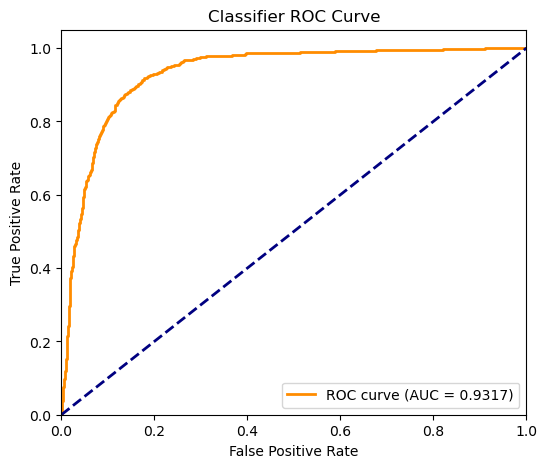

In [43]:
plot_roc_curve(all_labels, all_preds)

In [44]:
def visualize_reconstructions(model, dataloader, device, num_images=8, display_channel=0):
    """
    Visualizes a set of original images and their reconstructions.

    Args:
        model: The trained VAE model.
        dataloader: DataLoader for the unlabelled dataset.
        device: The device ('cuda' or 'cpu').
        num_images: Number of images to display.
        display_channel: For images with >3 channels, select which channel to display.
    """
    model.eval()
    originals, reconstructions = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            # Get reconstructions and latent variables from the model
            recon, mu, logvar = model(batch)
            originals.append(batch.cpu())
            reconstructions.append(recon.cpu())
            # Break when we've gathered enough images
            if torch.cat(originals, dim=0).size(0) >= num_images:
                break

    originals = torch.cat(originals, dim=0)[:num_images]
    reconstructions = torch.cat(reconstructions, dim=0)[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        img_orig = originals[i]
        img_recon = reconstructions[i]

        # If image has more than 3 channels, display only the chosen channel
        if img_orig.shape[0] not in [1, 3]:
            img_orig_disp = img_orig[display_channel].numpy()
            img_recon_disp = img_recon[display_channel].numpy()
            axes[0, i].imshow(img_orig_disp, cmap='gray')
            axes[1, i].imshow(img_recon_disp, cmap='gray')
        else:
            # For 1 or 3 channel images, display normally
            if img_orig.shape[0] == 1:
                axes[0, i].imshow(img_orig.squeeze(0).numpy(), cmap='gray')
                axes[1, i].imshow(img_recon.squeeze(0).numpy(), cmap='gray')
            else:
                # For 3 channel images, transpose to (H, W, C)
                axes[0, i].imshow(np.transpose(img_orig.numpy(), (1, 2, 0)))
                axes[1, i].imshow(np.transpose(img_recon.numpy(), (1, 2, 0)))

        axes[0, i].axis('off')
        axes[1, i].axis('off')

    axes[0, 0].set_title("Originals")
    axes[1, 0].set_title("Reconstructions")
    plt.show()

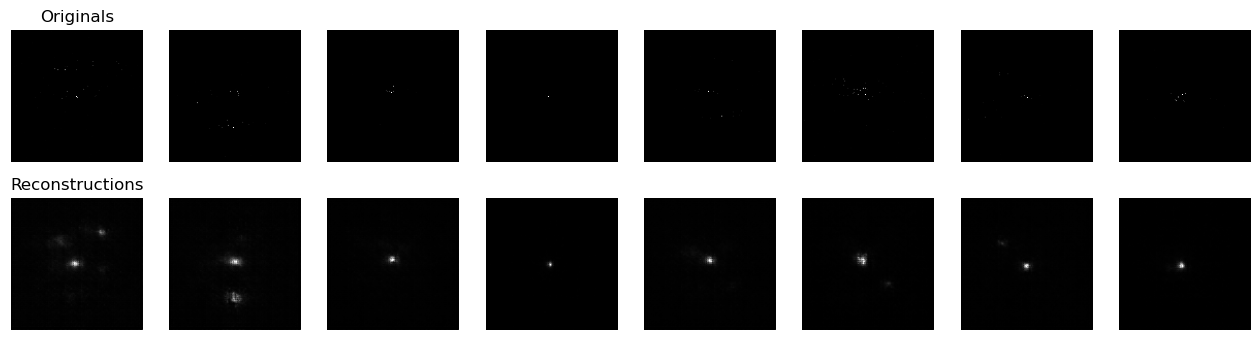

In [45]:
visualize_reconstructions(vae, unlabelled_loader, device, num_images=8, display_channel=0)

In [46]:
import torch.nn.functional as F

def compute_reconstruction_error(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, _, _ = model(batch)  # Get reconstructions from the VAE
            loss = F.mse_loss(recon, batch, reduction='sum')
            total_loss += loss.item()
            total_samples += batch.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss

# Example usage:
recon_error = compute_reconstruction_error(vae, unlabelled_loader, device)
print(f"Average Reconstruction Error (MSE) per sample: {recon_error:.4f}")

Average Reconstruction Error (MSE) per sample: 127.4355


In [6]:
import torch
from collections import OrderedDict
import warnings

warnings.filterwarnings(
    "ignore",
    message="TypedStorage is deprecated.*",
    category=UserWarning,
    module=r"torch\._utils"
)

import torch
from collections import OrderedDict

# Instantiate the model with the same parameters as used during training.
vae = VAE(latent_dim=128)

# Load the state dictionary.
state_dict = torch.load(
    './vae_enhanced_final.pth',
    map_location=torch.device('cpu'),
    weights_only=True
)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

vae.load_state_dict(new_state_dict)

# Move the model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): LeakyReLU(ne

In [49]:
import torch
from collections import OrderedDict

# Instantiating classifier with the same parameters
classifier = Classifier(vae, latent_dim=128).to(device)

# Load the saved state dictionary
state_dict = torch.load('./classifier_best.pth', map_location=torch.device('cpu'), weights_only=True)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k
    new_state_dict[name] = v

classifier.load_state_dict(new_state_dict)

# Move the classifier to device
classifier.to(device)
print("Classifier loaded successfully!")


Classifier loaded successfully!


In [50]:
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from ptflops import get_model_complexity_info
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Helper Function: Compute AUC
# ---------------------------
def compute_auc(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Apply sigmoid since outputs are logits
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs.ravel())
            all_labels.extend(labels.cpu().numpy())
    auc_value = roc_auc_score(all_labels, all_preds)
    return auc_value

In [51]:
# ---------------------------
# Pruning Functions
# ---------------------------
def prune_model(model, pruning_ratio):
    """
    Unstructured pruning: prune each Conv2d and Linear layer using L1 norm.
    """
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=pruning_ratio)
            prune.remove(module, 'weight')

def iterative_prune_and_finetune(model, train_loader, device, total_pruning_ratio, step_size=0.1, fine_tune_epochs=5):
    """
    Iteratively prune and fine-tune the model using training data.
    """
    pruned_model = copy.deepcopy(model)
    current_pruning_ratio = 0.0
    optimizer = optim.Adam(pruned_model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  # binary classification loss

    while current_pruning_ratio < total_pruning_ratio:
        step_pruning_ratio = min(step_size, total_pruning_ratio - current_pruning_ratio)
        # Applying unstructured pruning step
        for name, module in pruned_model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                prune.l1_unstructured(module, name='weight', amount=step_pruning_ratio / (1 - current_pruning_ratio))
                prune.remove(module, 'weight')
        # Fine-tuning pruned model
        pruned_model.train()
        for epoch in range(fine_tune_epochs):
            for batch in train_loader:
                images, labels = batch
                # Ensure image shape is as expected
                if images.shape[1:] != torch.Size([8, 128, 128]):
                    continue
                images = images.to(device)
                labels = labels.to(device)
                if labels.dim() == 1:
                    labels = labels.unsqueeze(1)
                optimizer.zero_grad()
                outputs = pruned_model(images)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()
        current_pruning_ratio += step_pruning_ratio
    return pruned_model

def prune_filters(model, pruning_ratio):
    """
    Structured pruning: remove entire filters from Conv2d layers based on L1 norm.
    """
    pruned_model = copy.deepcopy(model)
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d):
            weight = module.weight.data
            num_filters = weight.size(0)
            # Compute L1 norm for each filter
            norm = weight.abs().sum(dim=(1, 2, 3))
            num_prune = int(num_filters * pruning_ratio)
            if num_prune >= num_filters:
                continue
            prune_indices = norm.sort()[1][:num_prune]
            mask = torch.ones(num_filters, device=weight.device)
            mask[prune_indices] = 0
            new_weight = weight * mask.view(-1, 1, 1, 1)
            module.weight.data = new_weight
    return pruned_model


In [52]:
# ---------------------------
# Evaluate Original Classifier
# ---------------------------
original_auc = compute_auc(classifier, test_loader, device)
original_error = 1 - original_auc
original_flops, _ = get_model_complexity_info(classifier, (8, 128, 128), as_strings=False)
print(f'Original AUC: {original_auc:.4f}, Error (1-AUC): {original_error:.4f}, FLOPS: {original_flops:.2e}')

# ---------------------------
# Pruning Evaluation Setup
# ---------------------------
pruning_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sparsity_percent = [r * 100 for r in pruning_ratios]
errors = {'Unstructured': [], 'Iterative': [], 'Structured': []}
flops_list = {'Unstructured': [], 'Iterative': [], 'Structured': []}

total_iterations = len(pruning_ratios) * 3
print(f"\nStarting pruning evaluation with {total_iterations} iterations...")

for i, r in enumerate(pruning_ratios):
    start_time = time.time()

    # Unstructured Pruning
    pruned_classifier = copy.deepcopy(classifier)
    prune_model(pruned_classifier, r)
    auc_unstructured = compute_auc(pruned_classifier, test_loader, device)
    error_unstructured = 1 - auc_unstructured
    # Approximate FLOPS reduction: original FLOPS * (1 - pruning_ratio)
    flops_unstructured = original_flops * (1 - r)
    errors['Unstructured'].append(error_unstructured)
    flops_list['Unstructured'].append(flops_unstructured)

    # Iterative Pruning with Fine-Tuning
    pruned_classifier_iter = iterative_prune_and_finetune(classifier, train_loader, device, r)
    auc_iterative = compute_auc(pruned_classifier_iter, test_loader, device)
    error_iterative = 1 - auc_iterative
    flops_iterative = original_flops * (1 - r)
    errors['Iterative'].append(error_iterative)
    flops_list['Iterative'].append(flops_iterative)

    # Structured Pruning
    pruned_classifier_struct = prune_filters(classifier, r)
    auc_structured = compute_auc(pruned_classifier_struct, test_loader, device)
    error_structured = 1 - auc_structured
    flops_structured = original_flops * (1 - r)
    errors['Structured'].append(error_structured)
    flops_list['Structured'].append(flops_structured)

    end_time = time.time()
    iteration_time = end_time - start_time
    print(f"\nPruning Ratio {r:.1f}:")
    print(f"  Unstructured: AUC {auc_unstructured:.4f}, Error {error_unstructured:.4f}, FLOPS approx. {flops_unstructured:.2e}")
    print(f"  Iterative:    AUC {auc_iterative:.4f}, Error {error_iterative:.4f}, FLOPS approx. {flops_iterative:.2e}")
    print(f"  Structured:   AUC {auc_structured:.4f}, Error {error_structured:.4f}, FLOPS approx. {flops_structured:.2e}")
    print(f"  Iteration Time: {iteration_time:.2f} seconds")

Classifier(
  3.43 M, 100.000% Params, 21.55 MMac, 99.999% MACs, 
  (vae): VAE(
    3.42 M, 99.515% Params, 21.53 MMac, 99.922% MACs, 
    (encoder): Sequential(
      98.64 k, 2.873% Params, 19.37 MMac, 89.881% MACs, 
      (0): Conv2d(1.17 k, 0.034% Params, 4.78 MMac, 22.204% MACs, 8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, 0.001% Params, 131.07 KMac, 0.608% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(0, 0.000% Params, 65.54 KMac, 0.304% MACs, negative_slope=0.2)
      (3): Conv2d(4.64 k, 0.135% Params, 4.75 MMac, 22.052% MACs, 16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.304% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(0, 0.000% Params, 32.77 KMac, 0.152% MACs, negative_slope=0.2)
      (6): Conv2d(18.5 k, 0.539% Params, 4.73 MMac, 21.976% MACs, 32, 64, kernel_size=(3, 3),

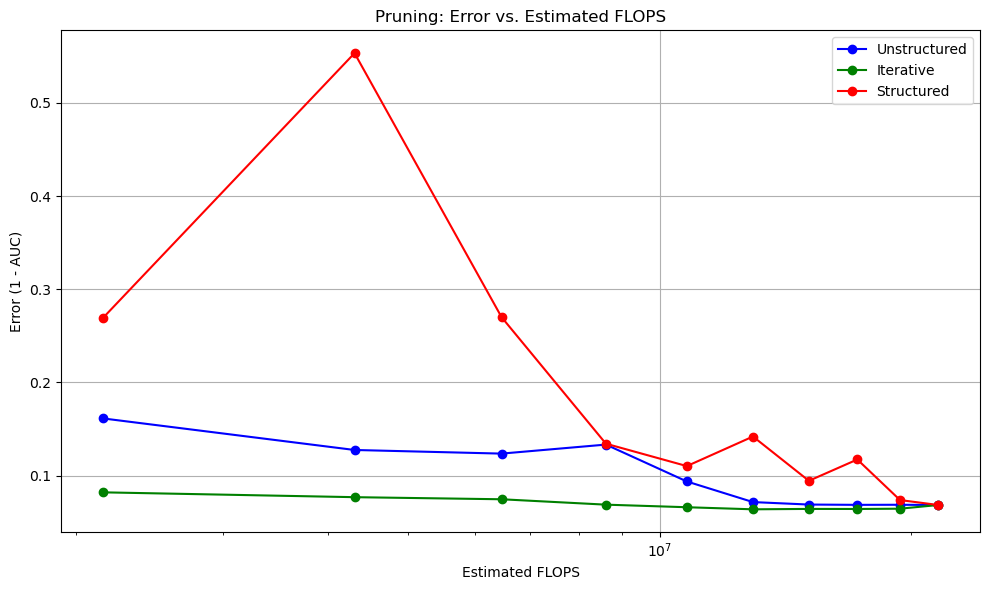

In [53]:
# ---------------------------
# Plot Error vs. FLOPS for Pruned Models
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(flops_list['Unstructured'], errors['Unstructured'], 'b-o', label='Unstructured')
plt.plot(flops_list['Iterative'], errors['Iterative'], 'g-o', label='Iterative')
plt.plot(flops_list['Structured'], errors['Structured'], 'r-o', label='Structured')
plt.xlabel('Estimated FLOPS')
plt.ylabel('Error (1 - AUC)')
plt.title('Pruning: Error vs. Estimated FLOPS')
plt.grid(True)
plt.xscale('log')  # using log scale
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
## BONUS task

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import numpy as np
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

# ---------------------------
# Loss Function for Sparse Autoencoder
# ---------------------------
def sparse_loss(recon, x, latent, sparsity_weight=1e-3):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    l1_penalty = sparsity_weight * torch.sum(torch.abs(latent))
    return recon_loss + l1_penalty

# ---------------------------
# Training Function for Sparse Autoencoder
# ---------------------------
def train_sparse_autoencoder(model, dataloader, optimizer, device, epoch, sparsity_weight=1e-3):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # For Sparse AE, forward returns (recon, latent)
        recon, latent = model(batch)
        loss = sparse_loss(recon, batch, latent, sparsity_weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}: Sparse AE Loss = {avg_loss:.4f}")
    return avg_loss

# ---------------------------
# Evaluation Function for Sparse AE: Reconstruction Error (MSE per sample)
# ---------------------------
def evaluate_reconstruction_sparse(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, latent = model(batch)
            loss = F.mse_loss(recon, batch, reduction='sum')
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# ---------------------------
# Define Sparse Autoencoder Architecture
# ---------------------------
class SparseAutoencoder(nn.Module):
    def __init__(self, input_shape=(8, 128, 128), latent_dim=128):
        super(SparseAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder (similar to baseline VAE encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        self.fc_enc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc_latent = nn.Linear(256, latent_dim)

        # Decoder (similar to baseline VAE decoder)
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # 32x32 -> 64x64
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),    # 64x64 -> 128x128
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_enc(h)
        latent = self.fc_latent(h)
        return latent  # Direct latent code; no reparameterization

    def decode(self, z):
        h = F.leaky_relu(self.decoder_input(z), 0.2)
        h = h.view(-1, 128, 8, 8)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        latent = self.encode(x)
        x_recon = self.decode(latent)
        return x_recon, latent

In [56]:
# ---------------------------
# Benchmarking: Compare Baseline VAE vs Sparse AE
# ---------------------------
# Assuming unlabelled_dataset and unlabelled_loader are defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

baseline_recon_error = 0.0
vae.eval()
with torch.no_grad():
    for batch in unlabelled_loader:
        batch = batch.to(device)
        recon, mu, logvar = vae(batch)
        loss = F.mse_loss(recon, batch, reduction='sum')
        baseline_recon_error += loss.item()
baseline_recon_error /= len(unlabelled_loader.dataset)
baseline_flops, _ = get_model_complexity_info(vae, (8, 128, 128), as_strings=False)
print(f"Baseline VAE: Recon Error = {baseline_recon_error:.4f}, FLOPS = {baseline_flops:.2e}")

Using device: cuda
VAE(
  3.42 M, 100.000% Params, 98.67 MMac, 100.000% MACs, 
  (encoder): Sequential(
    98.64 k, 2.887% Params, 19.37 MMac, 19.626% MACs, 
    (0): Conv2d(1.17 k, 0.034% Params, 4.78 MMac, 4.848% MACs, 8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, 0.001% Params, 131.07 KMac, 0.133% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(0, 0.000% Params, 65.54 KMac, 0.066% MACs, negative_slope=0.2)
    (3): Conv2d(4.64 k, 0.136% Params, 4.75 MMac, 4.815% MACs, 16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.066% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(0, 0.000% Params, 32.77 KMac, 0.033% MACs, negative_slope=0.2)
    (6): Conv2d(18.5 k, 0.541% Params, 4.73 MMac, 4.799% MACs, 32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, 0.004% Params, 32.7

In [57]:
# 2. Train Sparse Autoencoder for different sparsity weights
sparsity_weights = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]  # 0.0 means no L1 penalty (like baseline)

In [59]:
import os

sparse_results = []
for sw in sparsity_weights:
    filename = f"sparse_results_lambda_{sw}.pkl"
    if os.path.exists(filename):
        print(f"Results for λ = {sw} already exist. Loading from {filename}.")
        result = pickle.load(open(filename, "rb"))
        sparse_results.append(result)
        continue

    print(f"\nTraining Sparse AE with sparsity weight λ = {sw}")
    sparse_ae = SparseAutoencoder(latent_dim=128).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for Sparse AE training")
        sparse_ae = nn.DataParallel(sparse_ae)
    optimizer_sa = optim.Adam(sparse_ae.parameters(), lr=1e-3)
    num_epochs = 30
    best_loss = float('inf')
    patience = 3
    patience_counter = 0
    for epoch in range(num_epochs):
        epoch_loss = train_sparse_autoencoder(sparse_ae, unlabelled_loader, optimizer_sa, device, epoch, sparsity_weight=sw)
        improvement = best_loss - epoch_loss
        if improvement > 1.0:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} for sparsity weight λ = {sw}")
            break
    if isinstance(sparse_ae, nn.DataParallel):
        recon_error_sa = evaluate_reconstruction_sparse(sparse_ae.module, unlabelled_loader, device)
        flops_sa, _ = get_model_complexity_info(sparse_ae.module, (8, 128, 128), as_strings=False)
    else:
        recon_error_sa = evaluate_reconstruction_sparse(sparse_ae, unlabelled_loader, device)
        flops_sa, _ = get_model_complexity_info(sparse_ae, (8, 128, 128), as_strings=False)
    result = (sw, recon_error_sa, flops_sa)
    with open(filename, "wb") as f:
        pickle.dump(result, f)
    print(f"Results for λ = {sw} saved to {filename}")
    sparse_results.append(result)


Training Sparse AE with sparsity weight λ = 0.0
Using 4 GPUs for Sparse AE training
Epoch 1: Sparse AE Loss = 5111.7048
Epoch 2: Sparse AE Loss = 256.6146
Epoch 3: Sparse AE Loss = 169.1714
Epoch 4: Sparse AE Loss = 147.9089
Epoch 5: Sparse AE Loss = 137.6429
Epoch 6: Sparse AE Loss = 130.5821
Epoch 7: Sparse AE Loss = 124.4922
Epoch 8: Sparse AE Loss = 121.2439
Epoch 9: Sparse AE Loss = 119.5082
Epoch 10: Sparse AE Loss = 118.3740
Epoch 11: Sparse AE Loss = 117.5309
Epoch 12: Sparse AE Loss = 116.8711
Epoch 13: Sparse AE Loss = 116.3678
Epoch 14: Sparse AE Loss = 115.9651
Epoch 15: Sparse AE Loss = 115.6428
Epoch 16: Sparse AE Loss = 115.3585
Epoch 17: Sparse AE Loss = 115.1285
Epoch 18: Sparse AE Loss = 114.8928
Early stopping at epoch 18 for sparsity weight λ = 0.0
SparseAutoencoder(
  3.38 M, 100.000% Params, 98.64 MMac, 100.000% MACs, 
  (encoder): Sequential(
    98.64 k, 2.915% Params, 19.37 MMac, 19.633% MACs, 
    (0): Conv2d(1.17 k, 0.035% Params, 4.78 MMac, 4.850% MACs, 8, 

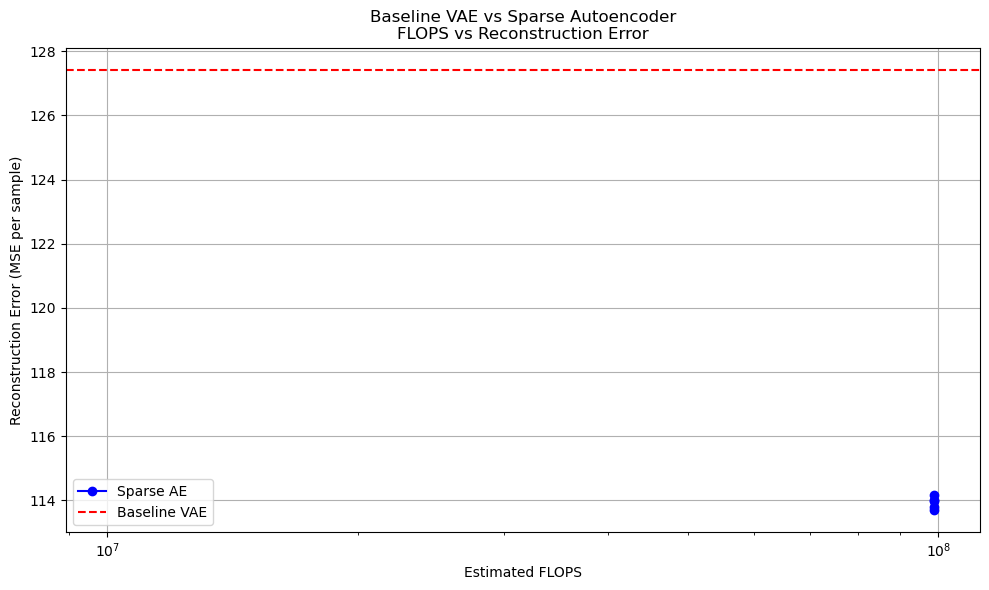

In [60]:
# Load the results, if in case training stops, then aggregate from files
loaded_results = []
for sw in sparsity_weights:
    filename = f"sparse_results_lambda_{sw}.pkl"
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            loaded_results.append(pickle.load(f))
    else:
        print(f"File {filename} not found; skipping.")

# ---------------------------
# Plot: FLOPS vs Reconstruction Error
# ---------------------------
flops_sparse = [res[2] for res in loaded_results]
errors_sparse = [res[1] for res in loaded_results]
sparsity_percent = [res[0] * 100 for res in loaded_results]

plt.figure(figsize=(10, 6))
plt.plot(flops_sparse, errors_sparse, 'bo-', label='Sparse AE')
plt.axhline(y=baseline_recon_error, color='r', linestyle='--', label='Baseline VAE')
plt.xlabel('Estimated FLOPS')
plt.ylabel('Reconstruction Error (MSE per sample)')
plt.title('Baseline VAE vs Sparse Autoencoder\nFLOPS vs Reconstruction Error')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()

In [61]:
######### end of bonus task #########